# Weakly Supervised Anomaly Detection with Classifier Guidance

This tutorial illustrates how to use MONAI for training a 2D gradient-guided anomaly detection using DDIMs [1].


[1] - Wolleb et al. "Diffusion Models for Medical Anomaly Detection" https://arxiv.org/abs/2203.04306


TODO: Add Open in Colab

## Setup environment

In [1]:
!python /home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/setup.py install
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn

running install
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing generative.egg-info/PKG-INFO
writing dependency_links to generative.egg-info/dependency_links.txt
writing requirements to generative.egg-info/requires.txt
writing top-level names to generative.egg-info/top_level.txt
reading manifest file 'generative.egg-info/SOURCES.txt'
writing manifest file 'generative.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build/bdist.linux-x86_64/egg
creating buil

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
import time
from typing import Dict
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset, DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
torch.multiprocessing.set_sharing_strategy('file_system')
import sys
sys.path.append('/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/')
print('path', sys.path)

from generative.inferers import DiffusionInferer


# TODO: Add right import reference after deployed
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet, DiffusionModelEncoder
from generative.networks.schedulers.ddpm import DDPMScheduler
from generative.networks.schedulers.ddim import DDIMScheduler
print_config()

path ['/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/tutorials/generative/classifier_guidance_anomalydetection', '/home/juliawolleb/anaconda3/envs/experiment/lib/python310.zip', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/lib-dynload', '', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/PyYAML-6.0-py3.10-linux-x86_64.egg', '/home/juliawolleb/PycharmProjects/Python_Tutorials/Calgary_Infants/calgary/HD-BET', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/lpips-0.1.4-py3.10.egg', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/tqdm-4.64.1-py3.10.egg', '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/generative-0.1.0-py3.10.egg', '/home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/']
MONAI version: 1.1.dev2248
Numpy ver

## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir='/home/juliawolleb/PycharmProjects/MONAI/brats'  #path to where the data is stored

## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Setup BRATS Dataset in 2D slices for training
As baseline, we use the load_2d_brats.ipynb written by Pedro in issue 150.
If we set `preprocessing_train=True`, we stack all slices into a tensor and save it as _total_train_slices.pt_. 
If we set `preprocessing_train=False`, we load the saved tensor.
The corresponding labels are saved as _total_train_labels.pt._

Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.



In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image","label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0 ).float().squeeze()),
    ]
)

/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [6]:

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print('len train data', len(train_ds))

def get_batched_2d_axial_slices(data : Dict):
    images_3D = data['image']
    batched_2d_slices = torch.cat(images_3D.split(1, dim = -1)[10:-10], 0).squeeze(-1) # we cut the lowest and highest 10 slices, because we are interested in the middle part of the brain.
    slice_label = data['slice_label']
    slice_label = torch.cat(slice_label.split(1, dim = -1)[10:-10],0).squeeze()
    return batched_2d_slices, slice_label

preprocessing_train=False

if preprocessing_train == True:
    train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
    print(f'Image shape {train_ds[0]["image"].shape}')

    data_2d_slices=[]
    data_slice_label = []
    check_data = first(train_loader_3D)
    for i, data in enumerate(train_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices.append(b2d)
        data_slice_label.append(slice_label2d)
    total_train_slices=torch.cat(data_2d_slices,0)
    total_train_labels=torch.cat(data_slice_label,0)

    torch.save(total_train_slices, 'total_train_slices.pt')
    torch.save(total_train_labels, 'total_train_labels.pt')

else:
    total_train_slices=torch.load('total_train_slices.pt')
    total_train_labels=torch.load('total_train_labels.pt')
    print('total slices', total_train_slices.shape)
    print('total lbaels', total_train_labels.shape)



len train data 388
total slices torch.Size([17072, 1, 64, 64])
total lbaels torch.Size([17072])


## Setup BRATS Dataset in 2D slices for validation 
As baseline, we use the load_2d_brats.ipynb written by Pedro in issue 150.
If we set `preprocessing_val=True`, we stack all slices into a tensor and save it as _total_val_slices.pt_.
If we set `preprocessing_val=False`, we load the saved tensor.
The corresponding labels are saved as _total_val_labels.pt_.

In [7]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)


preprocessing_val=False
if preprocessing_val == True:
    val_loader_3D = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)
    print(f'Image shape {val_ds[0]["image"].shape}')
    print('len val data', len(val_ds))
    data_2d_slices_val=[]
    data_slice_label_val = []
    for i, data in enumerate(val_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices_val.append(b2d)
        data_slice_label_val.append(slice_label2d)
    total_val_slices=torch.cat(data_2d_slices_val,0)
    total_val_labels=torch.cat(data_slice_label_val,0)
    torch.save(total_val_slices, 'total_val_slices.pt')
    torch.save(total_val_labels, 'total_val_labels.pt')

else:
    total_val_slices=torch.load('total_val_slices.pt')
    total_val_labels=torch.load('total_val_labels.pt')
    print('total slices', total_val_slices.shape)
    print('total lbaels', total_val_labels.shape)

total slices torch.Size([4224, 1, 64, 64])
total lbaels torch.Size([4224])


### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms
in the 3rd level (`num_head_channels=64`).


In [8]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
  #  cross_attention_dim=1,
)
model.to(device)

scheduler = DDIMScheduler(
    num_train_timesteps=1000,
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training of the Diffusion Model
If we set `train_diffusionmodel=True`, we are training our diffusion model for 75 epochs, and save the model as _diffusion_model.pt_.
If we set `train_diffusionmodel=False`, we load a pretrained model.

In [9]:
n_epochs =1
batch_size=32
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []

train_diffusionmodel=False

if train_diffusionmodel==False:
    model.load_state_dict(torch.load("model.pt", map_location={'cuda:0': 'cpu'}))
else:
    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        indexes = list(torch.randperm(total_train_slices.shape[0]))  #shuffle training data new
        data_train = total_train_slices[indexes]  # shuffle the training data
        labels_train = total_train_labels[indexes]
        subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))

        subset_2D_val = zip(total_val_slices.split(1), total_val_labels.split(1))  #

        progress_bar = tqdm(enumerate(subset_2D), total=len(indexes)/batch_size)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, (a,b) in progress_bar:
            images = a.to(device)
            classes = b.to(device)
            optimizer.zero_grad(set_to_none=True)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)  #pick a random time step t

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)  #remove the class conditioning

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            progress_bar.set_postfix(
                {
                    "loss": epoch_loss / (step + 1),
                }
            )
        epoch_loss_list.append(epoch_loss / (step + 1))


        if (epoch) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar_val = tqdm(enumerate(subset_2D_val))
            progress_bar.set_description(f"Epoch {epoch}")
            for    step, (a, b) in progress_bar_val:
                images = a.to(device)
                classes = b.to(device)

                timesteps = torch.randint(0, 1000, (len(images),)).to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix(
                    {
                        "val_loss": val_epoch_loss / (step + 1),
                    }
                )
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

    total_time = time.time() - total_start
    torch.save(model.state_dict(), "./diffusion_model.pt")  #save the trained model

    print(f"train diffusion completed, total time: {total_time}.")

    plt.style.use("seaborn-bright")
    plt.title("Learning Curves Diffusion Model", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()



## Define the Classification Model
First, we define the classification model. It follows the encoder architecture of the diffusion model, combined with linear layers for binary classification between healthy and diseased slices.


In [10]:
classifier = DiffusionModelEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    num_channels=(32,64,64),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
)
classifier.to(device)
batch_size=32

## Model training of the Classification Model
If we set `train_classifier=True`, we are training our diffusion model for 100 epochs, and save the model as _classifier.pt_.
If we set `train_classifier=False`, we load a pretrained model.

Epoch 0: : 534it [00:24, 21.51it/s, loss=0.534]                                 


final step train 533


Epoch 0: : 132it [00:01, 66.23it/s, val_loss=0.259]
Epoch 1: : 534it [00:27, 19.68it/s, loss=0.538]                                 


final step train 533


Epoch 1: : 132it [00:02, 57.32it/s, val_loss=0.28] 
Epoch 2: : 534it [00:27, 19.43it/s, loss=0.531]                                 


final step train 533


Epoch 2: : 132it [00:02, 60.17it/s, val_loss=0.32] 
Epoch 3: : 534it [00:27, 19.41it/s, loss=0.539]                                 


final step train 533


Epoch 3: : 132it [00:02, 58.98it/s, val_loss=0.294]
Epoch 4: : 534it [00:27, 19.40it/s, loss=0.536]                                 


final step train 533


Epoch 4: : 132it [00:02, 59.34it/s, val_loss=0.256]
Epoch 5: : 534it [00:27, 19.47it/s, loss=0.536]                                 


final step train 533


Epoch 5: : 132it [00:02, 59.58it/s, val_loss=0.278]
Epoch 6: : 534it [00:27, 19.49it/s, loss=0.53]                                  


final step train 533


Epoch 6: : 132it [00:02, 59.91it/s, val_loss=0.29] 
Epoch 7: : 534it [00:27, 19.58it/s, loss=0.533]                                 


final step train 533


Epoch 7: : 132it [00:02, 59.94it/s, val_loss=0.271]
Epoch 8: : 534it [00:27, 19.67it/s, loss=0.54]                                  


final step train 533


Epoch 8: : 132it [00:02, 60.28it/s, val_loss=0.261]
Epoch 9: : 534it [00:26, 19.84it/s, loss=0.535]                                 


final step train 533


Epoch 9: : 132it [00:02, 59.37it/s, val_loss=0.243]
Epoch 10: : 534it [00:27, 19.77it/s, loss=0.537]                                


final step train 533


Epoch 10: : 132it [00:02, 60.28it/s, val_loss=0.274]
Epoch 11: : 534it [00:26, 19.79it/s, loss=0.529]                                


final step train 533


Epoch 11: : 132it [00:02, 60.96it/s, val_loss=0.278]
Epoch 12: : 534it [00:26, 19.95it/s, loss=0.529]                                


final step train 533


Epoch 12: : 132it [00:02, 60.47it/s, val_loss=0.292]
Epoch 13: : 534it [00:26, 19.90it/s, loss=0.533]                                


final step train 533


Epoch 13: : 132it [00:02, 59.46it/s, val_loss=0.248]
Epoch 14: : 534it [00:26, 19.80it/s, loss=0.528]                                


final step train 533


Epoch 14: : 132it [00:02, 61.53it/s, val_loss=0.284]
Epoch 15: : 534it [00:26, 19.92it/s, loss=0.531]                                


final step train 533


Epoch 15: : 132it [00:02, 61.58it/s, val_loss=0.273]
Epoch 16: : 534it [00:26, 19.88it/s, loss=0.529]                                


final step train 533


Epoch 16: : 132it [00:02, 61.05it/s, val_loss=0.267]
Epoch 17: : 534it [00:26, 19.95it/s, loss=0.535]                                


final step train 533


Epoch 17: : 132it [00:02, 60.88it/s, val_loss=0.26] 
Epoch 18: : 534it [00:26, 19.83it/s, loss=0.533]                                


final step train 533


Epoch 18: : 132it [00:02, 60.91it/s, val_loss=0.318]
Epoch 19: : 534it [00:26, 20.29it/s, loss=0.528]                                


final step train 533


Epoch 19: : 132it [00:02, 63.26it/s, val_loss=0.265]
Epoch 20: : 534it [00:26, 19.84it/s, loss=0.532]                                


final step train 533


Epoch 20: : 132it [00:02, 60.27it/s, val_loss=0.289]
Epoch 21: : 534it [00:26, 20.11it/s, loss=0.534]                                


final step train 533


Epoch 21: : 132it [00:02, 60.49it/s, val_loss=0.27] 
Epoch 22: : 534it [00:26, 19.89it/s, loss=0.533]                                


final step train 533


Epoch 22: : 132it [00:02, 60.80it/s, val_loss=0.322]
Epoch 23: : 534it [00:26, 20.02it/s, loss=0.532]                                


final step train 533


Epoch 23: : 132it [00:02, 60.56it/s, val_loss=0.3]  
Epoch 24: : 534it [00:26, 20.01it/s, loss=0.526]                                


final step train 533


Epoch 24: : 132it [00:02, 60.69it/s, val_loss=0.287]
Epoch 25: : 534it [00:26, 20.00it/s, loss=0.524]                                


final step train 533


Epoch 25: : 132it [00:02, 61.55it/s, val_loss=0.263]
Epoch 26: : 534it [00:26, 20.04it/s, loss=0.528]                                


final step train 533


Epoch 26: : 132it [00:02, 61.16it/s, val_loss=0.328]
Epoch 27: : 534it [00:26, 19.95it/s, loss=0.533]                                


final step train 533


Epoch 27: : 132it [00:02, 61.15it/s, val_loss=0.263]
Epoch 28: : 534it [00:26, 20.06it/s, loss=0.528]                                


final step train 533


Epoch 28: : 132it [00:02, 60.67it/s, val_loss=0.292]
Epoch 29: : 534it [00:26, 20.10it/s, loss=0.528]                                


final step train 533


Epoch 29: : 132it [00:02, 61.57it/s, val_loss=0.294]
Epoch 30: : 534it [00:26, 19.98it/s, loss=0.53]                                 


final step train 533


Epoch 30: : 132it [00:02, 61.60it/s, val_loss=0.284]
Epoch 31: : 534it [00:26, 20.08it/s, loss=0.53]                                 


final step train 533


Epoch 31: : 132it [00:02, 61.04it/s, val_loss=0.276]
Epoch 32: : 534it [00:26, 19.86it/s, loss=0.525]                                


final step train 533


Epoch 32: : 132it [00:02, 62.82it/s, val_loss=0.285]
Epoch 33: : 534it [00:26, 20.13it/s, loss=0.525]                                


final step train 533


Epoch 33: : 132it [00:02, 61.12it/s, val_loss=0.277]
Epoch 34: : 534it [00:26, 20.05it/s, loss=0.53]                                 


final step train 533


Epoch 34: : 132it [00:02, 61.71it/s, val_loss=0.278]
Epoch 35: : 534it [00:26, 20.08it/s, loss=0.526]                                


final step train 533


Epoch 35: : 132it [00:02, 62.17it/s, val_loss=0.27] 
Epoch 36: : 534it [00:26, 20.21it/s, loss=0.525]                                


final step train 533


Epoch 36: : 132it [00:02, 62.01it/s, val_loss=0.267]
Epoch 37: : 534it [00:26, 20.04it/s, loss=0.523]                                


final step train 533


Epoch 37: : 132it [00:02, 61.29it/s, val_loss=0.278]
Epoch 38: : 534it [00:26, 20.21it/s, loss=0.523]                                


final step train 533


Epoch 38: : 132it [00:02, 62.59it/s, val_loss=0.285]
Epoch 39: : 534it [00:26, 20.13it/s, loss=0.526]                                


final step train 533


Epoch 39: : 132it [00:02, 60.36it/s, val_loss=0.279]
Epoch 40: : 534it [00:26, 20.04it/s, loss=0.532]                                


final step train 533


Epoch 40: : 132it [00:02, 61.89it/s, val_loss=0.274]
Epoch 41: : 534it [00:26, 20.00it/s, loss=0.528]                                


final step train 533


Epoch 41: : 132it [00:02, 61.62it/s, val_loss=0.275]
Epoch 42: : 534it [00:26, 20.11it/s, loss=0.527]                                


final step train 533


Epoch 42: : 132it [00:02, 61.35it/s, val_loss=0.308]
Epoch 43: : 534it [00:26, 19.83it/s, loss=0.529]                                


final step train 533


Epoch 43: : 132it [00:02, 60.97it/s, val_loss=0.31] 
Epoch 44: : 534it [00:26, 20.22it/s, loss=0.526]                                


final step train 533


Epoch 44: : 132it [00:02, 61.49it/s, val_loss=0.306]
Epoch 45: : 534it [00:26, 19.95it/s, loss=0.523]                                


final step train 533


Epoch 45: : 132it [00:02, 60.71it/s, val_loss=0.293]
Epoch 46: : 534it [00:26, 20.02it/s, loss=0.526]                                


final step train 533


Epoch 46: : 132it [00:02, 61.20it/s, val_loss=0.254]
Epoch 47: : 534it [00:26, 19.88it/s, loss=0.526]                                


final step train 533


Epoch 47: : 132it [00:02, 61.35it/s, val_loss=0.253]
Epoch 48: : 534it [00:26, 20.19it/s, loss=0.526]                                


final step train 533


Epoch 48: : 132it [00:02, 61.04it/s, val_loss=0.274]
Epoch 49: : 534it [00:26, 19.95it/s, loss=0.523]                                


final step train 533


Epoch 49: : 132it [00:02, 61.74it/s, val_loss=0.28] 
Epoch 50: : 534it [00:26, 20.03it/s, loss=0.525]                                


final step train 533


Epoch 50: : 132it [00:02, 59.53it/s, val_loss=0.292]
Epoch 51: : 534it [00:26, 19.93it/s, loss=0.52]                                 


final step train 533


Epoch 51: : 132it [00:02, 60.65it/s, val_loss=0.299]
Epoch 52: : 534it [00:26, 19.89it/s, loss=0.526]                                


final step train 533


Epoch 52: : 132it [00:02, 61.33it/s, val_loss=0.279]
Epoch 53: : 534it [00:26, 20.04it/s, loss=0.52]                                 


final step train 533


Epoch 53: : 132it [00:02, 61.07it/s, val_loss=0.282]
Epoch 54: : 534it [00:26, 19.83it/s, loss=0.524]                                


final step train 533


Epoch 54: : 132it [00:02, 60.71it/s, val_loss=0.296]
Epoch 55: : 534it [00:26, 20.05it/s, loss=0.521]                                


final step train 533


Epoch 55: : 132it [00:02, 60.82it/s, val_loss=0.296]
Epoch 56: : 534it [00:26, 19.90it/s, loss=0.524]                                


final step train 533


Epoch 56: : 132it [00:02, 60.35it/s, val_loss=0.288]
Epoch 57: : 534it [00:26, 19.92it/s, loss=0.522]                                


final step train 533


Epoch 57: : 132it [00:02, 60.57it/s, val_loss=0.279]
Epoch 58: : 534it [00:27, 19.76it/s, loss=0.523]                                


final step train 533


Epoch 58: : 132it [00:02, 61.55it/s, val_loss=0.265]
Epoch 59: : 534it [00:26, 19.85it/s, loss=0.525]                                


final step train 533


Epoch 59: : 132it [00:02, 60.26it/s, val_loss=0.309]
Epoch 60: : 534it [00:26, 19.94it/s, loss=0.521]                                


final step train 533


Epoch 60: : 132it [00:02, 60.22it/s, val_loss=0.284]
Epoch 61: : 534it [00:27, 19.57it/s, loss=0.523]                                


final step train 533


Epoch 61: : 132it [00:02, 58.50it/s, val_loss=0.267]
Epoch 62: : 534it [00:27, 19.67it/s, loss=0.527]                                


final step train 533


Epoch 62: : 132it [00:02, 61.49it/s, val_loss=0.278]
Epoch 63: : 534it [00:27, 19.65it/s, loss=0.523]                                


final step train 533


Epoch 63: : 132it [00:02, 59.89it/s, val_loss=0.291]
Epoch 64: : 534it [00:27, 19.59it/s, loss=0.52]                                 


final step train 533


Epoch 64: : 132it [00:02, 61.56it/s, val_loss=0.31] 
Epoch 65: : 534it [00:27, 19.39it/s, loss=0.517]                                


final step train 533


Epoch 65: : 132it [00:02, 55.48it/s, val_loss=0.353]
Epoch 66: : 534it [00:28, 19.05it/s, loss=0.516]                                


final step train 533


Epoch 66: : 132it [00:02, 56.32it/s, val_loss=0.294]
Epoch 67: : 534it [00:27, 19.12it/s, loss=0.524]                                


final step train 533


Epoch 67: : 132it [00:02, 57.70it/s, val_loss=0.303]
Epoch 68: : 534it [00:27, 19.11it/s, loss=0.521]                                


final step train 533


Epoch 68: : 132it [00:02, 56.41it/s, val_loss=0.278]
Epoch 69: : 534it [00:27, 19.10it/s, loss=0.523]                                


final step train 533


Epoch 69: : 132it [00:02, 58.40it/s, val_loss=0.302]
Epoch 70: : 534it [00:27, 19.32it/s, loss=0.517]                                


final step train 533


Epoch 70: : 132it [00:02, 59.59it/s, val_loss=0.285]
Epoch 71: : 534it [00:27, 19.31it/s, loss=0.518]                                


final step train 533


Epoch 71: : 132it [00:02, 58.24it/s, val_loss=0.302]
Epoch 72: : 534it [00:27, 19.33it/s, loss=0.525]                                


final step train 533


Epoch 72: : 132it [00:02, 59.33it/s, val_loss=0.301]
Epoch 73: : 534it [00:27, 19.47it/s, loss=0.522]                                


final step train 533


Epoch 73: : 132it [00:02, 59.77it/s, val_loss=0.301]
Epoch 74: : 534it [00:26, 19.83it/s, loss=0.523]                                


final step train 533


Epoch 74: : 132it [00:02, 60.28it/s, val_loss=0.321]
Epoch 75: : 534it [00:26, 19.82it/s, loss=0.523]                                


final step train 533


Epoch 75: : 132it [00:02, 59.62it/s, val_loss=0.3]  
Epoch 76: : 534it [00:26, 19.90it/s, loss=0.518]                                


final step train 533


Epoch 76: : 132it [00:02, 60.27it/s, val_loss=0.292]
Epoch 77: : 534it [00:26, 19.87it/s, loss=0.522]                                


final step train 533


Epoch 77: : 132it [00:02, 60.70it/s, val_loss=0.302]
Epoch 78: : 534it [00:26, 19.78it/s, loss=0.522]                                


final step train 533


Epoch 78: : 132it [00:02, 59.56it/s, val_loss=0.292]
Epoch 79: : 534it [00:26, 19.85it/s, loss=0.524]                                


final step train 533


Epoch 79: : 132it [00:02, 61.08it/s, val_loss=0.29] 
Epoch 80: : 534it [00:27, 19.76it/s, loss=0.518]                                


final step train 533


Epoch 80: : 132it [00:02, 59.27it/s, val_loss=0.305]
Epoch 81: : 534it [00:26, 19.92it/s, loss=0.517]                                


final step train 533


Epoch 81: : 132it [00:02, 61.01it/s, val_loss=0.314]
Epoch 82: : 534it [00:27, 19.75it/s, loss=0.515]                                


final step train 533


Epoch 82: : 132it [00:02, 59.88it/s, val_loss=0.309]
Epoch 83: : 534it [00:26, 19.84it/s, loss=0.52]                                 


final step train 533


Epoch 83: : 132it [00:02, 59.66it/s, val_loss=0.296]
Epoch 84: : 534it [00:27, 19.69it/s, loss=0.519]                                


final step train 533


Epoch 84: : 132it [00:02, 59.83it/s, val_loss=0.332]
Epoch 85: : 534it [00:26, 19.85it/s, loss=0.522]                                


final step train 533


Epoch 85: : 132it [00:02, 59.60it/s, val_loss=0.317]
Epoch 86: : 534it [00:27, 19.77it/s, loss=0.522]                                


final step train 533


Epoch 86: : 132it [00:02, 58.63it/s, val_loss=0.302]
Epoch 87: : 534it [00:26, 19.79it/s, loss=0.519]                                


final step train 533


Epoch 87: : 132it [00:02, 60.47it/s, val_loss=0.296]
Epoch 88: : 534it [00:27, 19.74it/s, loss=0.515]                                


final step train 533


Epoch 88: : 132it [00:02, 60.28it/s, val_loss=0.312]
Epoch 89: : 534it [00:26, 19.89it/s, loss=0.524]                                


final step train 533


Epoch 89: : 132it [00:02, 60.52it/s, val_loss=0.289]
Epoch 90: : 534it [00:26, 19.79it/s, loss=0.519]                                


final step train 533


Epoch 90: : 132it [00:02, 59.43it/s, val_loss=0.332]
Epoch 91: : 534it [00:26, 19.82it/s, loss=0.517]                                


final step train 533


Epoch 91: : 132it [00:02, 60.42it/s, val_loss=0.31] 
Epoch 92: : 534it [00:26, 19.81it/s, loss=0.514]                                


final step train 533


Epoch 92: : 132it [00:02, 59.98it/s, val_loss=0.299]
Epoch 93: : 534it [00:26, 19.90it/s, loss=0.524]                                


final step train 533


Epoch 93: : 132it [00:02, 61.64it/s, val_loss=0.315]
Epoch 94: : 534it [00:26, 19.84it/s, loss=0.516]                                


final step train 533


Epoch 94: : 132it [00:02, 60.29it/s, val_loss=0.331]
Epoch 95: : 534it [00:26, 19.84it/s, loss=0.514]                                


final step train 533


Epoch 95: : 132it [00:02, 61.00it/s, val_loss=0.306]
Epoch 96: : 534it [00:27, 19.72it/s, loss=0.52]                                 


final step train 533


Epoch 96: : 132it [00:02, 59.72it/s, val_loss=0.307]
Epoch 97: : 534it [00:26, 19.99it/s, loss=0.52]                                 


final step train 533


Epoch 97: : 132it [00:02, 60.52it/s, val_loss=0.336]
Epoch 98: : 534it [00:26, 19.83it/s, loss=0.512]                                


final step train 533


Epoch 98: : 132it [00:02, 60.33it/s, val_loss=0.36] 
Epoch 99: : 534it [00:26, 19.87it/s, loss=0.514]                                


final step train 533


Epoch 99: : 132it [00:02, 60.57it/s, val_loss=0.327]


train completed, total time: 2959.368038415909.
epl 100


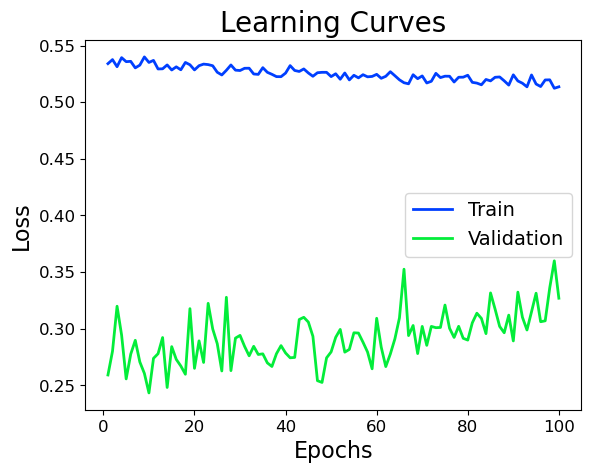

In [110]:
train_classifier=True

n_epochs = 100
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []
optimizer_cls = torch.optim.Adam(params=classifier.parameters(),  lr=2.5e-5)

classifier.to(device)
weight=torch.tensor((3,1)).float().to(device) #account for the class imbalance in the dataset


if train_classifier==False:
    classifier.load_state_dict(torch.load("./classifier_small.pt", map_location={'cuda:0': 'cpu'}))
else:

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        classifier.train()
        epoch_loss = 0
        indexes = list(torch.randperm(total_train_slices.shape[0]))
        data_train = total_train_slices[indexes]  # shuffle the training data
        labels_train = total_train_labels[indexes]
        subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))
        progress_bar = tqdm(enumerate(subset_2D), total=len(indexes)/batch_size)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (a,b) in progress_bar:
            images = a.to(device)
            classes = b.to(device)
            
            optimizer_cls.zero_grad(set_to_none=True)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)

            with autocast(enabled=False):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Get model prediction
                noisy_img=scheduler.add_noise(images,noise, timesteps )   #add t steps of noise to the input image
                pred=classifier(noisy_img, timesteps)
                loss = F.cross_entropy(pred, classes.long(), weight=weight, reduction="mean")

            loss.backward()
            optimizer_cls.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(
                    {
                        "loss": epoch_loss / (step + 1),
                    }
                )
        epoch_loss_list.append(epoch_loss / (step + 1))
        print('final step train', step)


        if (epoch + 1) % val_interval == 0:
            classifier.eval()
            val_epoch_loss = 0
            subset_2D_val = zip(total_val_slices.split(batch_size), total_val_labels.split(batch_size))  #
            progress_bar_val = tqdm(enumerate(subset_2D_val))
            progress_bar_val.set_description(f"Epoch {epoch}")
            for step, (a,b) in progress_bar_val:
                images = a.to(device)
                classes = b.to(device)
                timesteps = torch.randint(0, 1, (len(images),)).to(device)  #check validation accuracy on the original images, i.e., do not add noise

                with torch.no_grad():
                    with autocast(enabled=False):
                        noise = torch.randn_like(images).to(device)
                        pred = classifier(images, timesteps)
                        val_loss = F.cross_entropy(pred, classes.long(), reduction="mean")

                val_epoch_loss += val_loss.item()
                _, predicted = torch.max(pred, 1);
                progress_bar_val.set_postfix(
                    {
                        "val_loss": val_epoch_loss / (step + 1),
                    }
                )
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))


    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")
    torch.save(classifier.state_dict(), "./classifier_100.pt")
    
    ## Learning curves for the Classifier
    
    plt.style.use("seaborn-bright")
    plt.title("Learning Curves", fontsize=20)
    print('epl', len(epoch_loss_list))
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

# Image-to-Image Translation to a Healthy Subject
We pick a diseased subject of the validation set as input image. We want to translate it to its healthy reconstruction.

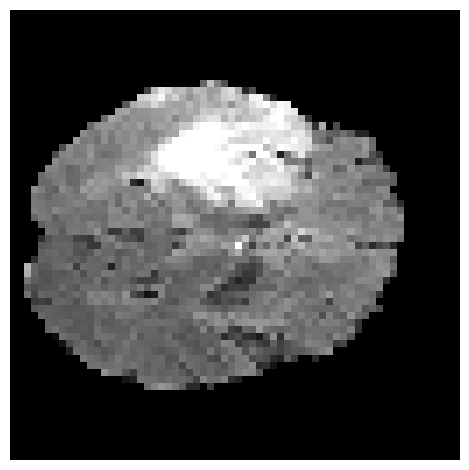

DiffusionModelEncoder(
  (conv_in): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (o

In [124]:


inputimg = total_val_slices[150][0,...]  # Pick an input slice of the validation set to be transformed   
inputlabel= total_val_labels[150]        # Check whether it is healthy or diseased

plt.figure("input"+str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

model.eval()
classifier.eval()

### Encoding the input image in noise with the reversed DDIM sampling scheme
In order to sample using gradient guidance, we first need to encode the input image in noise by using the reversed DDIM sampling scheme.\
We define the number of steps in the noising and denoising process by L.\
The encoding process is presented in Equation of the paper "Diffusion Models for Medical Anomaly Detection" (https://arxiv.org/pdf/2203.04306.pdf).


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 44.00it/s]


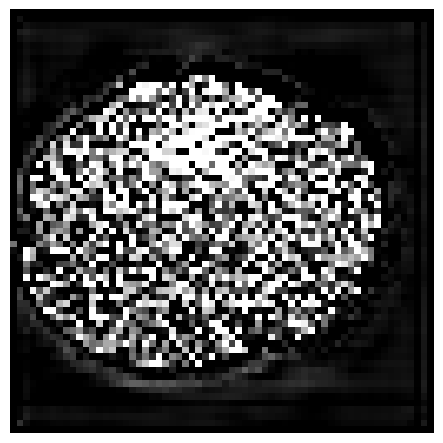

In [125]:
L=200
current_img = inputimg[None,None,...].to(device)
scheduler.set_timesteps(num_inference_steps=1000)


progress_bar = tqdm(range(L))   #go back and forth L timesteps
for t in progress_bar:  #go through the noising process

    with autocast(enabled=False):
        with torch.no_grad():
            model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device))
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)

plt.style.use("default")
plt.imshow(current_img[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()



### Denoising Process using Gradient Guidance
From the noisy image, we apply DDIM sampling scheme for denoising for L steps.
Additionally, we apply gradient guidance using the classifier network towards the desired class label y=0 (healthy). This is presented in Algorithm 2 of https://arxiv.org/pdf/2105.05233.pdf, and in Algorithm 1 of https://arxiv.org/pdf/2203.04306.pdf. \
The scale s is used to amplify the gradient.

100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 17.41it/s]


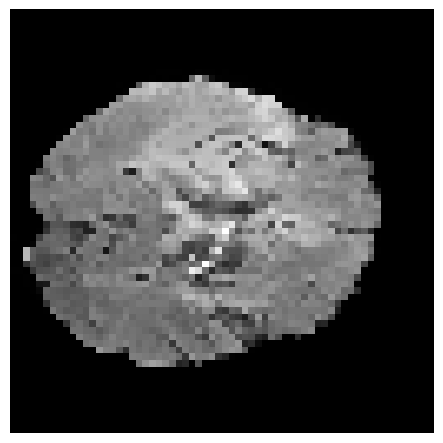

In [126]:


y=torch.tensor(0)  #define the desired class label
scale=5     #define the desired gradient scale s
progress_bar = tqdm(range(L))   #go back and forth L timesteps

for i in progress_bar:  #go through the denoising process

    t=L-i
    with autocast(enabled=True):
        with torch.no_grad():
            model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device)).detach() # this is supposed to be epsilon

        with torch.enable_grad():
            x_in = current_img.detach().requires_grad_(True)
            logits = classifier(x_in, timesteps=torch.Tensor((t,)).to(current_img.device))
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y.view(-1)]
            a = torch.autograd.grad(selected.sum(), x_in)[0]
            alpha_prod_t = scheduler.alphas_cumprod[t]
            updated_noise = model_output- (1 - alpha_prod_t).sqrt() * scale*a  #update the predicted noise epsilon with the gradient of the classifier

    current_img, _ = scheduler.step(updated_noise, t, current_img)
    torch.cuda.empty_cache()

plt.style.use("default")
plt.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

# Anomaly Detection
To get the anomaly map, we compute the difference between the input image the output of our image-to-image translation model, which is the healthy reconstruction.

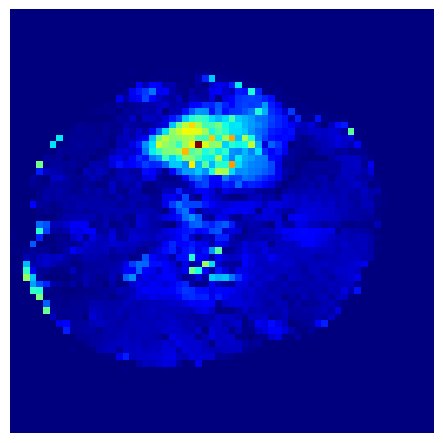

In [127]:
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min)/ (_max - _min)
    return normalized_img

diff=abs(inputimg.cpu()-current_img[0, 0].cpu()).detach().numpy()
plt.style.use("default")
plt.imshow(diff, cmap="jet")
plt.tight_layout()
plt.axis("off")
plt.show()